# 2. EDA

## 2.1 Time series analysis

Let's explore overall dynamic within all sales

**Periodic patterns**

`yearly`

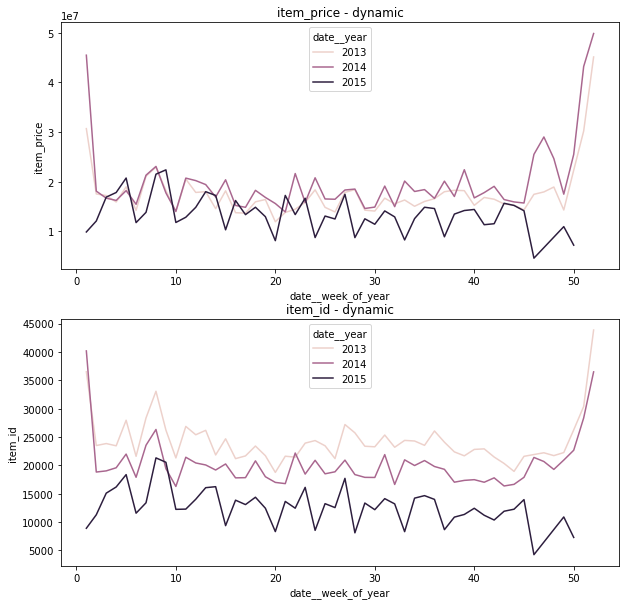

In [58]:
p_year_patterns = imm_flat_df.groupby(['date__week_of_year', 'date__year']).agg({
    'item_price': 'sum',
    'item_id': 'count',
}).reset_index()

fig, axs = plt.subplots(len(p_year_patterns.columns) - 2, 1, figsize=(10, (len(p_year_patterns.columns) - 2) * 5))
    
for idx, col in enumerate(p_year_patterns.columns[2:]):
    sns.lineplot(data=p_year_patterns, x='date__week_of_year', y=col, hue='date__year', ax=axs[idx]).set_title(f"{col} - dynamic")

`monthly`

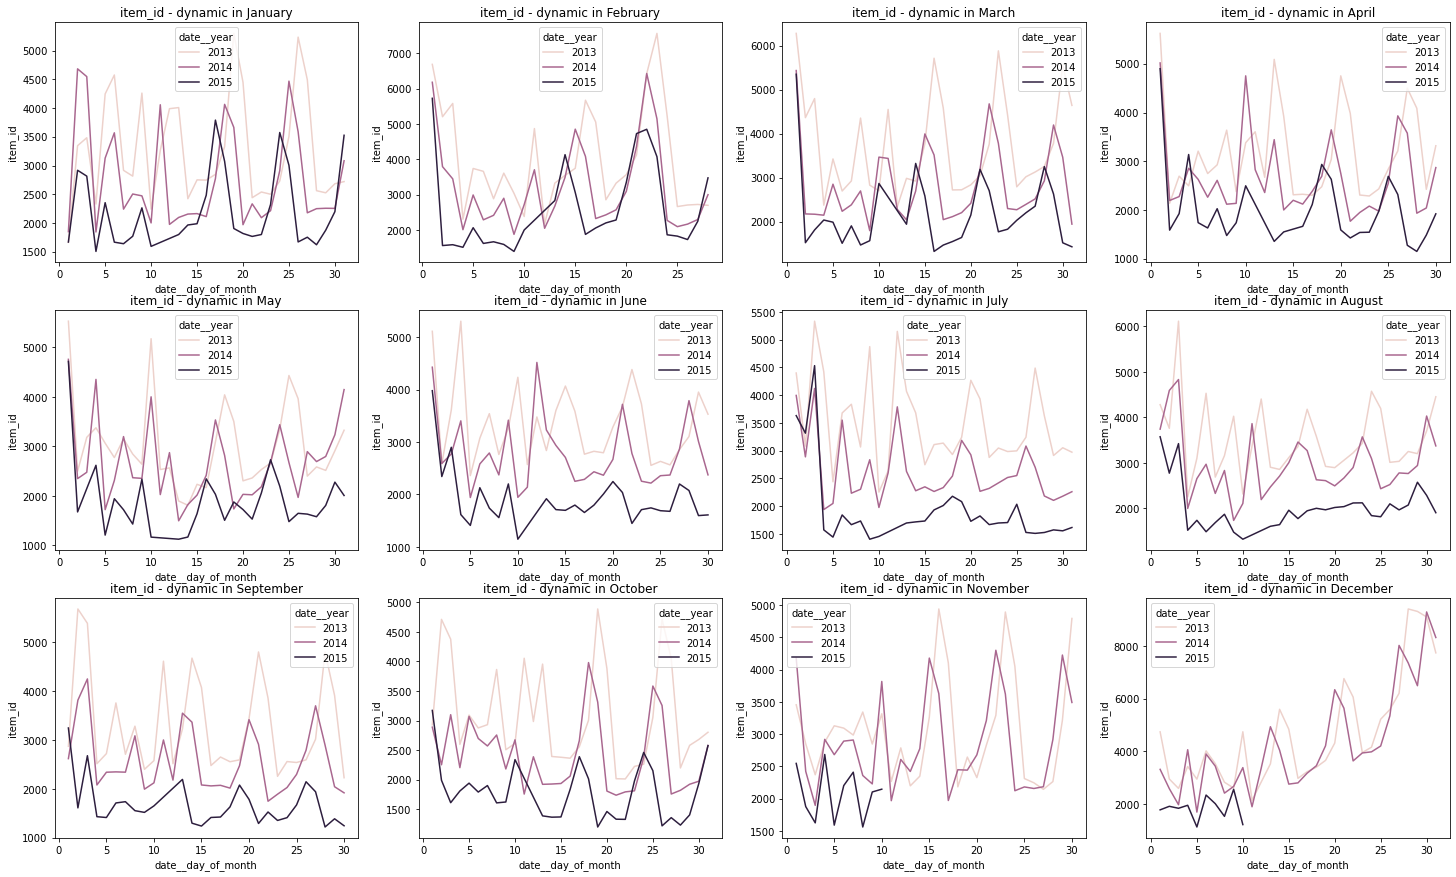

In [59]:
import calendar


p_year_patterns = imm_flat_df.groupby(['date__day_of_month', 'date__month_of_year', 'date__year']).agg({
    'item_id': 'count',
}).reset_index()

fig, axs = plt.subplots(3, 4, figsize=(25, 15))
    
for month in range(1,13):
    sns.lineplot(data=p_year_patterns[p_year_patterns.date__month_of_year == month], x='date__day_of_month', y='item_id', hue='date__year', ax=axs[(month - 1) // 4][(month - 1) % 4]).set_title(f"{col} - dynamic in {calendar.month_name[month]}")

#### What can we get through this pics:
 - We cannot include `December and November 2015` into training set since it's incomplete
 - Data in general looks pretty correlated and have some seasonal patterns
 - Last year 2015 has much smaller sale rate rather then in 2014 and 2015

**Periodic patterns: autocorrelation and partial autocorrelation**

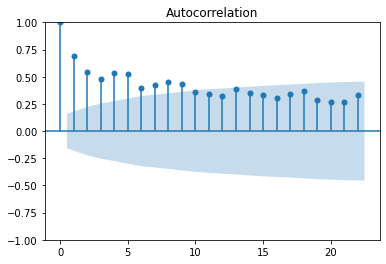

In [60]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf, acf, pacf

imm_weekly_dynamic = (imm_flat_df
     .groupby('date__weeks_since_hstart')
     .agg({'item_id': 'count'})
     .reset_index()
     .sort_values('date__weeks_since_hstart', ascending=True))

res = plot_acf(x=imm_weekly_dynamic.item_id)

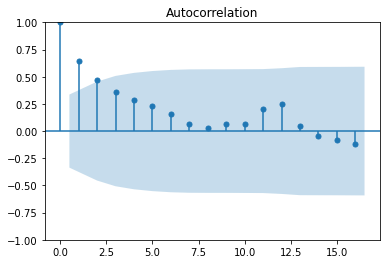

In [61]:
imm_monthly_dynamic = (imm_flat_df
     .groupby('date__month_since_hstart')
     .agg({'item_id': 'count'})
     .reset_index()
     .sort_values('date__month_since_hstart', ascending=True))

res = plot_acf(x=imm_monthly_dynamic.item_id)

As we can see, we might obtain `ACF` results as well as confidence intervals to obtain most common lag dependencies

## 2.2. Categorical investigation

### 2.2.1. Shops

ACF distribution among lags

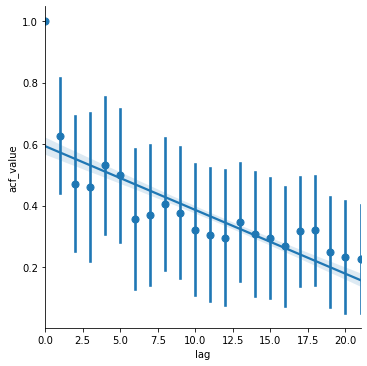

In [62]:
shop_acf_report = eda__create_categorical_acf_report(imm_flat_df, cat_col='shop_id', ts_col='date__weeks_since_hstart', agg_map={'item_id': 'count'})

sns.lmplot(data=shop_acf_report, x='lag', y='acf_value', x_estimator=np.median, x_ci='sd')

Here we can see `median_ACF` value among all shops
 - Important lags: [1 week, 1 month, 4 months]

In [63]:
def tokenize(s):
    import re
    return list(filter(lambda x: x != '', re.split('\?|!|,| |$|\(|\)|"', s)))

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    
vectorizer = TfidfVectorizer(tokenizer=tokenize)
    
matrix = vectorizer.fit_transform(data['shops'].shop_name).toarray()
vocab_mapping = pd.DataFrame(data=vectorizer.vocabulary_.items(), columns=['word', 'id']).sort_values('id')
doc_report = pd.DataFrame(data=matrix, columns=vocab_mapping.word)

In [64]:
top_popular_words = doc_report.transpose().sum(axis=1).reset_index().rename({0: 'count'}, axis=1).sort_values('count', ascending=False)
top_popular_words.head(30).transpose()

,96,54,95,50,91,94,109,104,97,76,60,26,53,7,78,75,57,68,40,44,99,5,64,101,20,87,21,51,29,98
word,тц,москва,трц,мега,тк,трк,якутск,центральный,тюмень,ростовнадону,новосибирск,воронеж,молл,ii,самара,рио,н.новгород,паркхаус,казань,красноярск,уфа,56,орджоникидзе,фран,буденовский,спб,век,мегацентр,горизонт,ул.
count,7.59987,4.79654,4.03793,3.49528,2.32666,2.30517,2.14378,1.82492,1.70188,1.64754,1.59595,1.58053,1.46444,1.41403,1.32126,1.28706,1.2571,1.24846,1.21788,1.1714,1.15277,1.11736,1.11736,1.11192,1.10496,1.08088,1.00988,0.989465,0.989465,0.974471


Possible features:
 - City name
 - Shop location type
 - Shop embedding ???

**Dynamic clusterization**

In [65]:
imm_flat_df.shop_name.value_counts()

Москва ТЦ "Семеновский"                            235184
Москва ТРК "Атриум"                                185786
Химки ТЦ "Мега"                                    143122
Москва ТЦ "МЕГА Теплый Стан" II                    142018
Якутск Орджоникидзе, 56                            117114
СПб ТК "Невский Центр"                             109001
Москва ТЦ "МЕГА Белая Дача II"                     105207
Воронеж (Плехановская, 13)                          82402
Якутск ТЦ "Центральный"                             71268
Чехов ТРЦ "Карнавал"                                69378
Сергиев Посад ТЦ "7Я"                               66219
Тюмень ТЦ "Гудвин"                                  65043
Курск ТЦ "Пушкинский"                               63700
Калуга ТРЦ "XXI век"                                59380
Н.Новгород ТРЦ "Фантастика"                         58317
Москва МТРЦ "Афи Молл"                              58008
Воронеж ТРЦ "Максимир"                              57977
Сургут ТРЦ "Си

In [66]:
def shop_name2city(sn):
    sn = sn.split()[0]
    if sn == 'Цифровой' or sn == 'Интернет-магазин': sn = 'Internet'
    if sn[0] == '!': sn = sn[1:]  
    return sn

imm_flat_df['city'] = imm_flat_df['shop_name'].apply(shop_name2city)
imm_flat_df['city_enc'] = LabelEncoder().fit_transform(imm_flat_df['city']).astype('int8')



imm_flat_df['city_size'] = imm_flat_df['city'].map(city_info['city_size'])

In [67]:
imm_flat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928462 entries, 0 to 2928461
Data columns (total 20 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   date__month_since_hstart  int64         
 2   shop_id                   int64         
 3   item_id                   int64         
 4   item_price                float64       
 5   item_cnt_day              float64       
 6   item_name                 object        
 7   item_category_id          int64         
 8   item_category_name        object        
 9   shop_name                 object        
 10  date__days_since_hstart   int64         
 11  date__weeks_since_hstart  int64         
 12  date__day_of_month        int64         
 13  date__day_of_week         int64         
 14  date__week_of_year        int64         
 15  date__month_of_year       int64         
 16  date__year                int64         
 17  city    

In [68]:
imm_flat_df = imm_flat_df.drop_duplicates()

In [75]:
df=imm_flat_df.pivot_table(index=['shop_id', 'item_id'], columns='date__month_since_hstart', values='item_cnt_day', aggfunc='sum').fillna(0.0)
df.head()

date__month_since_hstart   0     1    2    3    4    5    6    7    8    9   \
shop_id item_id                                                               
0       30                0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31                0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32                6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33                3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35                1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date__month_since_hstart   10   11   12   13   14   15   16   17   18   19  \
shop_id item_id                                                              
0       30                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date__month_since_hstart   20   21   22   23   24   25   26   27   28   29  \
shop_id item_id                                                              
0       30                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date__month_since_hstart   30   31   32   33  
shop_id item_id                               
0       30                0.0  0.0  0.0  0.0  
        31                0.0  0.0  0.0  0.0  
        32                0.0  0.0  0.0  0.0  
        33                0.0  0.0  0.0  0.0  
        35                0.0  0.0  0.0  0.0

In [76]:
train_df = df.reset_index()
train_df["shop_id"] = train_df.shop_id.astype("str")
train_df["item_id"] = train_df.item_id.astype("str")
train_df.head()

date__month_since_hstart,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
item_cat_df = data['items'].merge(data['item_categories'][['item_category_id','item_category_name']], how="inner", on="item_category_id")[['item_id','item_category_name']]

In [96]:
item_cat_df['item_id'] = item_cat_df.item_id.astype('str')

In [97]:
train_df = train_df.merge(item_cat_df, how="inner", on="item_id")

In [78]:
!pip install xgboost
from sklearn import *
import xgboost as xgb

In [99]:
EN = preprocessing.LabelEncoder()
train_df['item_category_name'] = EN.fit_transform(train_df['item_category_name'])
train_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_category_name
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


In [101]:
train_df['item_category_name'] = EN.fit_transform(train_df['item_category_name'])
train_df = train_df[['shop_id', 'item_id', 'item_category_name'] + list(range(34))]
train_df.head()

,shop_id,item_id,item_category_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,30,40,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,40,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,40,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,40,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,40,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
from sklearn.metrics import mean_squared_error


In [103]:
param = {'max_depth': 15, 
         'subsample': 1,
         'min_child_weight': 1,
         'eta':0.34, 
         'seed':1,
         'verbosity': 1,
         'eval_metric':'rmse'}



xgbtrain = xgb.DMatrix(train_df.iloc[:,  (train_df.columns != 33)].values,
                       train_df.iloc[:, train_df.columns == 33].values)

model = xgb.train(param, xgbtrain)
preds = model.predict(xgb.DMatrix(train_df.iloc[:,  (train_df.columns != 33)].values))
RMSE = np.sqrt(mean_squared_error(preds,train_df.iloc[:, train_df.columns == 33].values))

print(RMSE)

0.6986882165849309


In [104]:
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

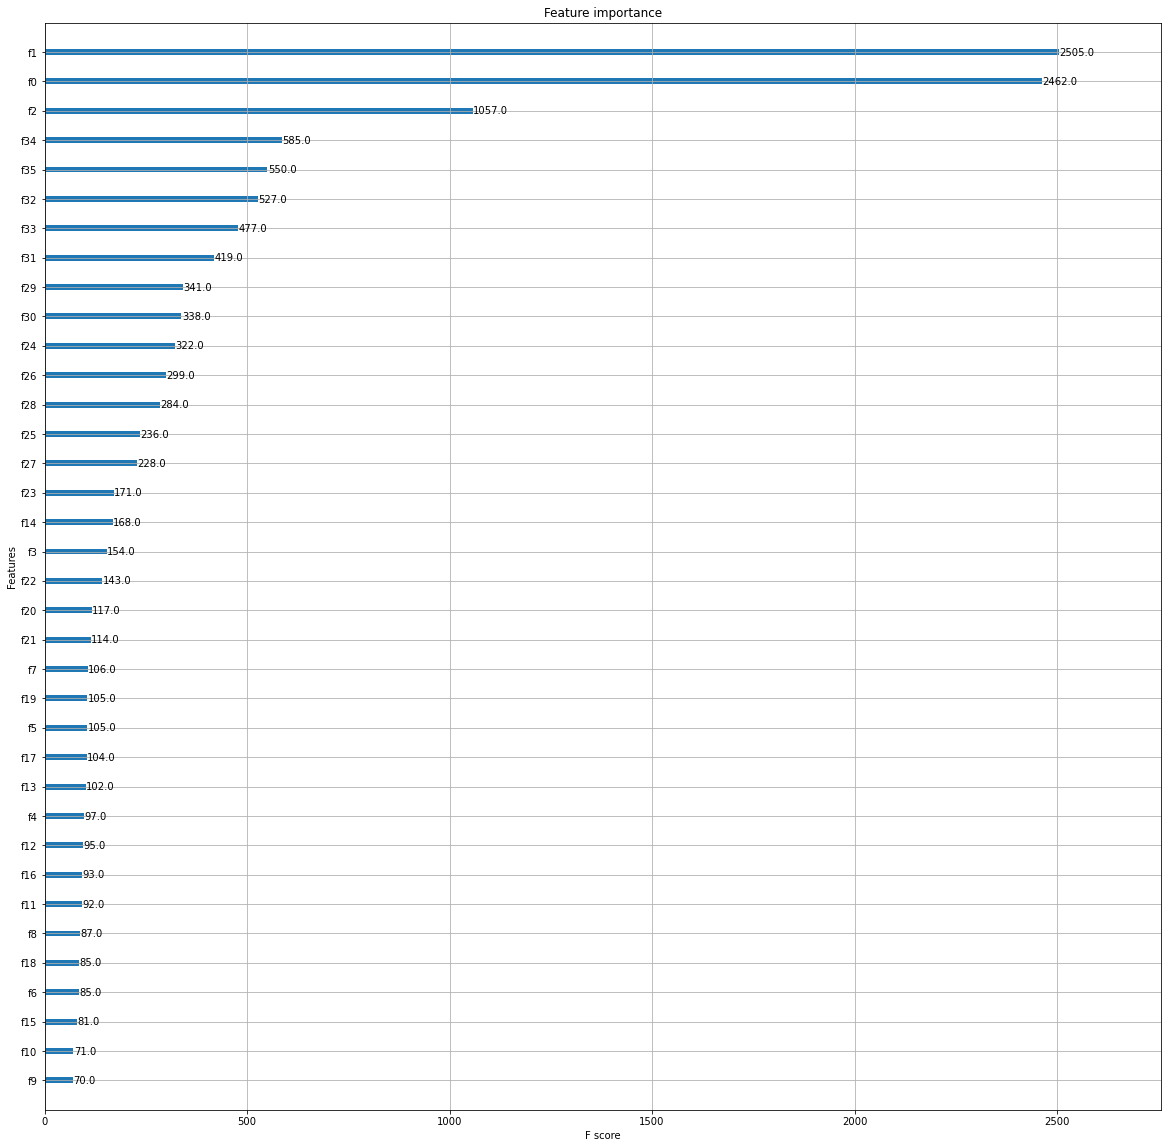

In [105]:
fig, ax = plt.subplots(figsize = (20, 20))
xgb.plot_importance(model, ax = ax)

In [118]:
test = pd.read_csv('./competitive-data-science-predict-future-sales/provided_data/test.csv')

In [119]:
test.shop_id = test.shop_id.astype('str')
test.item_id = test.item_id.astype('str')

In [120]:
test = test.merge(train_df, how="left", on=["shop_id", "item_id"]).fillna(0.0)
test.head()

,ID,shop_id,item_id,item_category_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
d = dict(zip(test.columns[4:],list(np.array(list(test.columns[4:])) - 1)))

test = test.rename(d, axis = 1)

In [122]:
predictions = model.predict(xgb.DMatrix(test.iloc[:, (test.columns != 'ID') & (test.columns != -1)].values))

In [124]:
predictions = list(map(lambda x: min(20, max(x,0)), list(predictions)))
submission = pd.DataFrame({'ID': test.ID, 'item_cnt_month': predictions})
submission.to_csv('govno.csv', index=False)